# Misil

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate, optimize

## Apartado 1

En primer lugar se introducen las variables geométricas del misil y las características del vuelo.

Variables geométricas:

In [65]:
# ----- Generales ----- #
D = 0.1778	                 # Diámetro del misil. (m)
r0 = D/2	                 # Radio del misil. (m)
l_misil = 3.7                    # Longitud del misil (m)
l_b = 0.08                       # Longitud del boattail (m)
l = 0.41	                 # Longitud de la ojiva. (m)
m_misil = 152                    # Masa del misil (kg)
S = r0**2*np.pi                  # Superficie transversal del misil (m^2)
Sb = ((D-0.06)/2)**2*np.pi       # Superficie de la base (m^2)
ang_ojiva = 2*np.arctan(D/(2*l)) # Ángulo de la ojiva

# ----- Superficies aerodinámicas ----- #
tr = 0.0055	# Ancho máximo de las alas. (m)
cr_w = 0.3      # Cuerda alas. (m)
cr_c = 0.315    # Cuerda superficies de control. (m)
λ = 6.5/31.5
mac = 2/3*cr_c*(1+λ+λ**2)/(1+λ)     # Cuerda media aerodinámica
m = 0.3         # Distancia borde de ataque a punto espesor máximo.
Bc = 2*0.219+D  # Wingspan (m)
Bw = 2*0.17+D   # Wingspan ala (m)
deflx_w = 0.9  # Deflexión de la estela, término (1-dew/dalpha)
Sc = 2*((0.315-0.065)*0.063 + (0.219-0.063)*0.065 + (0.315 - 0.065) *
        (0.219 - 0.063)*0.5)     # Superficie alar de los controles (m^2)
Sw = 2 * 0.3*0.17/2              # Superficie alar (m^2)

# ----- Distancias de interés ------ #
Xcg = (l_misil - 1.51)                                  # Distancia al centro de gravedad.
Xw = (2.06-cr_w/2)                                      # Distancia al centro de presiones del ala.
Xc = l_misil-l_b - cr_c + (0.315-mac) + mac/2           # Distancia al centro de presiones del control.
Xb = 2/3*l                                              # Distancia al centro de presiones del fuselaje.


Condiciones del vuelo:

In [66]:
AOA = 0 		# Ángulo de ataque (deg).
M = 4           # Mach de vuelo
h = 10000       # Altura de vuelo (m)
δ_deflx = 10    # Deflexión del control (deg)

En este apartado se ajustan las diferentes variables para que tengan las unidades requeridas, además de calcular otras variables que se precisen y que no sean introducidas por el usuario.

In [67]:
# ----- Correcciones angulares ----- #
δ_deflx = δ_deflx*np.pi/180
AOA = np.pi*AOA/180
ang_ojiva = ang_ojiva*180/np.pi
α = AOA

# ----- Propiedades de la corriente libre ----- #
β = (M**2-1)**0.5                          # Parámetro de corrección de compresibilidad
ρ = (1.225*(1-22.558*10**(-6)*h)**4.2559)  # Densidad a la altura de vuelo
dens = ρ * 0.00194032
R_cte = 1718
Tinf = 1.8*(288.15-6.5*h/1000)
Patm = dens*Tinf*R_cte
Tfree = (288.15-6.5*h/1000)                # Temperatura de la corriente libre en K.
mu0 = 3.58*10**(-7)                        # Viscosidad en unidades del sistema imperial

# ----- Velocidades y presión dinámica ----- #
Vsound = (1.4*Tfree*287)**0.5	# Velocidad del sonido a la altura de vuelo
Vinf_I = M*Vsound				# Velocidad de la corriente libre en el sistema internacional
q = 1/2*Vinf_I**2*ρ

# ----- Otras variables ----- #
dl = 50         # Divisiones del misil para las funciones de la capa límite.
g = 9.81		# Gravedad (m/s^2)


Para el cálculo de la resistencia generada en el misil como consecuencia del vuelo al Mach indicado, se ha tomado la gráfica disponible en el $\textit{Missile Aerodynamics}$ y se ha representado, interpolándose los diferentes valores que se obtienen de esta.

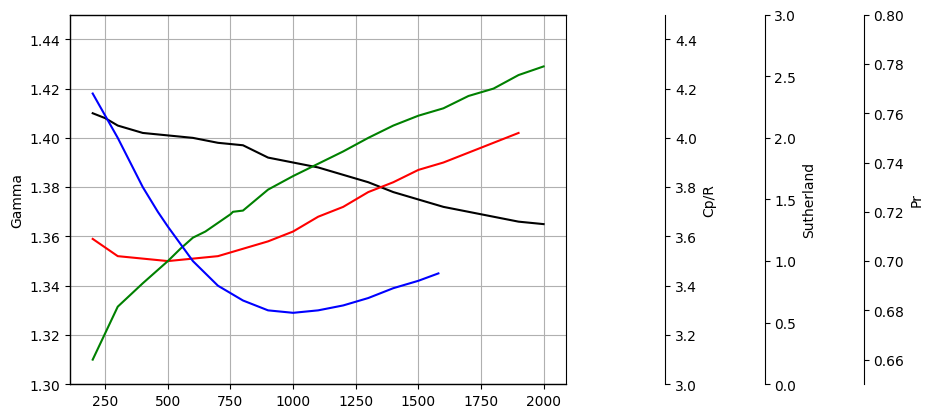

In [68]:
Temp_Pr = [200, 300, 350, 400, 460, 500, 600, 700, 800,
           850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1580]
Pr_datos = [0.768, 0.75, 0.74, 0.73, 0.72, 0.714, 0.7, 0.69, 0.684,
            0.682, 0.68, 0.679, 0.68, 0.682, 0.685, 0.689, 0.692, 0.695]
Temp_gamma = [200, 250, 300, 400, 500, 600, 700, 800, 900, 1000,
              1100, 1200, 1300, 1350, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
gamma_datos = [1.41, 1.408, 1.405, 1.402, 1.401, 1.4, 1.398, 1.397, 1.392, 1.39,
               1.388, 1.385, 1.382, 1.38, 1.378, 1.375, 1.372, 1.37, 1.368, 1.366, 1.365]
Temp_cp = [200, 300, 400, 500, 600, 700, 800, 900, 1000,
           1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
cp_datos = [3.59, 3.52, 3.51, 3.5, 3.51, 3.52, 3.55, 3.58,
            3.62, 3.68, 3.72, 3.78, 3.82, 3.87, 3.9, 3.94, 3.98, 4.02]
Temp_mu = [200, 300, 400, 500, 550, 600, 650, 700, 750, 760, 800, 900,
           1000, 1050, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
mu_datos = [0.2, 0.63, 0.82, 1, 1.1, 1.19, 1.24, 1.31, 1.38, 1.4, 1.41,
            1.58, 1.69, 1.74, 1.79, 1.89, 2, 2.1, 2.18, 2.24, 2.34, 2.4, 2.51, 2.58]
Pr = interpolate.CubicSpline(Temp_Pr, Pr_datos)
gamma = interpolate.CubicSpline(Temp_gamma, gamma_datos)
cp = interpolate.CubicSpline(Temp_cp, cp_datos)
mu = interpolate.CubicSpline(Temp_mu, mu_datos)
def Grafica_plot():
	fig, ax = plt.subplots()
	cp_pl = ax.twinx()
	muRel_pl = ax.twinx()
	Pr_pl = ax.twinx()
	cp_pl.plot(Temp_cp, cp(Temp_cp), 'r-', label="Cp/R")
	cp_pl.set_ylim(3, 4.5)
	cp_pl.spines.right.set_position(("axes", 1.2))
	cp_pl.set_ylabel("Cp/R")

	muRel_pl.plot(Temp_mu, mu(Temp_mu), 'g-', label="Sutherland")
	muRel_pl.spines.right.set_position(("axes", 1.4))
	muRel_pl.set_ylim(0, 3)
	muRel_pl.set_ylabel("Sutherland")

	Pr_pl.plot(Temp_Pr, Pr(Temp_Pr), 'b-', label="Prandtl")
	Pr_pl.set_ylim(0.65, 0.8)
	Pr_pl.spines.right.set_position(("axes", 1.6))
	Pr_pl.set_ylabel("Pr")

	ax.plot(Temp_gamma, gamma(Temp_gamma), "k-", label="Gamma")
	ax.set_ylim(1.3, 1.45)
	ax.set_ylabel("Gamma")
	ax.grid(True)
	plt.show()
Grafica_plot()

A continuación se procede a calcular los diferentes tipos de drag para obtener el total requerido.

El drag debido al lift en un cuerpo esbelto de base cilíndrica es la mitad del que se produce en una placa plana, tal y como se indica en el libro $\textit{Missile Aerodynamics}$. Si el ángulo de ataque es 0, esta resistencia y la denominada como $\textit{viscous crossflow drag}$ son 0.

In [69]:
L_q = 2*np.pi*AOA*r0**2         # Sustentación de una placa plana
D_q = 0.5*L_q*AOA               # Resistencia debida al AOA / presión dinámica
print("Resistencia inducida por la sustentación: ", D_q*q)

Resistencia inducida por la sustentación:  0.0


La resistencia frontal se calculará tanto el la ojiva como en las superficies de control, puesto que son las que generan las ondas de choque correspondientes. Para ello, se han considerado ambas superficies de control de perfil de forma romboidal de parámetro m el indicado en la celda de parámetros geométricos. Esta resistencia se calcula para ángulo de ataque 0, tal y como se indica en la bibliografía.

In [70]:
Vinf = (gamma(Tinf)*R_cte*Tinf)**0.5*M                  # Velocidad de la corriente libre
# Drag frontal en las alas.
Cd0w = 1/(4*m*(1-m))*4*(tr/cr_w)**2/β
# Drag frontal en los controles.
Cd0c = 1/(4*m*(1-m))*4*(tr/cr_c)**2/β
Cdwc = (0.083+0.096/M**2)*(ang_ojiva/10)**1.69 * \
    (1-(392*(l/D)**2-32)/(28*(M+18)*(l/D)**2))          # Drag frontal ojiva
D_frontal = Cdwc*S*q+Cd0w*4*S*q+Cd0c*4*S*q
print("Coeficiente de resistencia alas: ", Cd0w)
print("Coeficiente de resistencia controles: ", Cd0c)
print("Coeficiente de resistencia ojiva: ", Cdwc)
print("Resistencia frontal: ",D_frontal)

Coeficiente de resistencia alas:  0.00041325483676463626
Coeficiente de resistencia controles:  0.0003748343190608945
Coeficiente de resistencia ojiva:  0.15076607488985855
Resistencia frontal:  1131.285619538455


In [71]:
Cdb_s = 0.10/(l_b/(D/2))**2
Cdb = Cdb_s * Sb/S
Db = Cdb * q * S
print("Coeficiente de resistencia boattail: ", Cdb)
print("Drag boattail: ",Db)

Coeficiente de resistencia boattail:  0.05420640625000001
Drag boattail:  398.41185538744963


Finalmente, se calcula la resistencia de fricción. En este caso, los coeficientes adimensionales se encuentran calculados para un área genérica, por lo que la superficie a emplear a la hora de calcular las fuerzas resistentes es directamente la superficie mojada, que será obtenida posteriormente.

Para el cálculo de este drag, se ha empleado el método de la entalpía media tal y como aparece en la bibliografía. Por este motivo, se definieron las siguientes funciones:

In [72]:
# Función de cálculo de la densidad de referencia en la capa límite.
def dens_ref(T): return Patm/(R_cte*T)
def Re(x, ρ, μ): return Vinf*ρ*x/μ 					# Reynolds
# Coeficiente de fricción para caso laminar.
def cf_laminar(x, ρ, μ): return 0.664*Re(x, ρ, μ)**(-0.5)
# Coeficiente de fricción para el caso turbulento.
def cf_turbulento(x, ρ, μ): return 0.370/(np.log10(Re(x, ρ, μ))**2.584)

Después, se establecen las ecuaciones que permitirán calcular las propiedades del fluido en la capa límite laminar y en la turbulenta.

In [73]:
def Laminar(T):
	"Función que calcula la capa límite laminar en función de la temperatura exterior"
	Titer = 1800		# Temperatura de inicio de la iteración
	Tref = Titer
	while True:
		r = Pr(Titer)**0.5
		Ts = T*(1+(gamma(T)-1)/2*M**2)
		Trec = T + r*(Ts-T)
		Tref = T + 0.5*(Trec-T)+0.22*r*(Ts-T)
		if abs(Titer-Tref) <= 0.00001:
			break
		Titer = Tref
	mu_ref = mu(Tref)*mu0
	# Promedio
	Re_medio = Re(x=l_misil*3.281, ρ=dens_ref(Tref), μ=mu_ref)
	cf_medio = 0.664*2/(Re_medio**0.5)
	# Local
	x_misil = np.linspace(0.5, l_misil*3.281, dl)
	cf_local = []
	i = 0
	while Re(x=x_misil[i], ρ=dens_ref(Tref), μ=mu_ref) < 10**7:
		# La capa límite laminar está presente hasta el punto de transición.
		cf_local.append(cf_laminar(x=x_misil[i], ρ=dens_ref(Tref), μ=mu_ref))
		i += 1
	xT = x_misil[i-1]
	θ = xT*cf_local[i-1]		# Momentum thickness
	δ = 5*x_misil/(Re(x=x_misil, ρ=dens_ref(Tref), μ=mu_ref)** 0.5)  # Espesor capa límite
	displ_thickness = 1.72*x_misil / (Re(x=x_misil, ρ=dens_ref(Tref), μ=mu_ref)**0.5)  # Displacement thickness
	return cf_local, xT, θ, δ, dens_ref(Tref), cf_medio, displ_thickness

El punto más problemático de este análisis es la localización de la transición de laminar a turbulento. En este caso se ha obtenido considerando un Reynolds crítico y, para un mejor estudio de los cambios en las propiedades del fluido se requieren otras variables conocidas como $\textit{displacement thickness}$ ($\delta^*$) y $\textit{momentum thickness}$ ($\theta$).

In [74]:
θ = Laminar(Tinf)[2]
xT = Laminar(Tinf)[1]	# Punto de transición

El punto xT es aquel en el que se supera el Reynolds de $10^7$, donde empezarán a actuar las ecuaciones de la capa límite turbulenta.

In [75]:
def Turbulenta(T, θ, xT):
	"Función que calcula la capa límite turbulenta en función de la temperatura exterior"
	Titer = 1800
	Tref = Titer
	while True:
		r = Pr(Titer)**(1/3)
		Ts = T*(1+(gamma(T)-1)/2*M**2)
		Trec = T + r*(Ts-T)
		Tref = T + 0.5*(Trec-T)+0.22*r*(Ts-T)
		if abs(Titer-Tref) <= 0.00001:
			break
		Titer = Tref
	mu_ref = mu(Tref)*mu0
	x_misil = np.linspace(0, l_misil*3.281, dl)
	cf_local = [cf_turbulento(x=coord, ρ=dens_ref(Tref), μ=mu_ref) for coord in x_misil if coord > 0]
	Δx = 0
	for i in range(0, len(x_misil)-1):
		θturb = x_misil[i]*cf_local[i]/2
		if abs(θturb - θ) < 0.000001:
			Δx = 2*θ/cf_local[i]  # Referencia Missile Aerodynamics
			break
	x_compensado = xT - Δx

	x_misil_compensado = [(coord - x_compensado) for coord in x_misil]
	def delta_BLayer(x, ρ, μ): return 0.37*x/(Re(x, ρ, μ)**(1/5))
	δ = [delta_BLayer(x=coord, ρ=dens_ref(Tref), μ=mu_ref)/(D*3.281)
            for coord in x_misil_compensado if coord > 0]
	cf_local = [cf_turbulento(x=coord, ρ=dens_ref(Tref), μ=mu_ref)
             for coord in x_misil_compensado if coord > 0]
	return cf_local, δ, dens_ref(Tref)


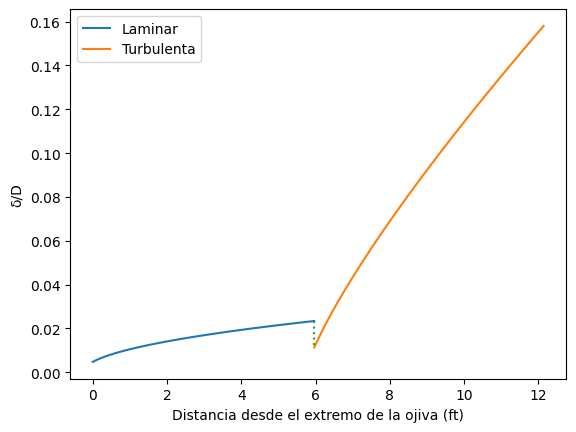

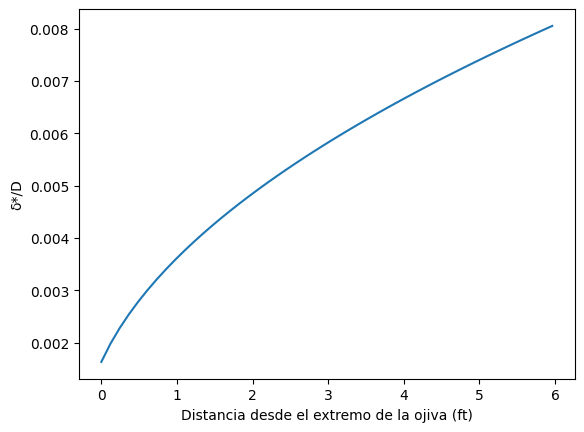

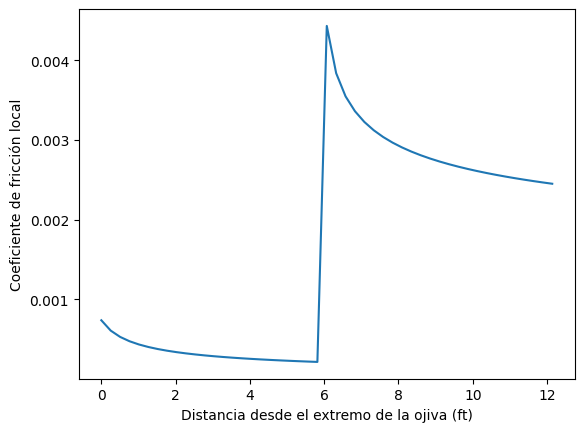

In [76]:
dens_lam, dens_turb, displ_thickness = Laminar(Tinf)[4], Turbulenta(Tinf, θ, xT)[2], Laminar(Tinf)[6]/(D*3.281)
BL_laminar = np.array(Laminar(Tinf)[0])
BL_turbulenta = Turbulenta(Tinf, θ, xT)[0]
cf_local = np.append(BL_laminar, BL_turbulenta)
cf_local_ojiva = interpolate.CubicSpline(
	np.linspace(0, l, len(BL_laminar)), BL_laminar)
cf_local_laminar = interpolate.CubicSpline(
	np.linspace(0, xT/3.281, len(BL_laminar)), BL_laminar)
cf_local_turbulento = interpolate.CubicSpline(np.linspace(xT/3.281, l_misil, len(BL_turbulenta)), BL_turbulenta)

Cdf_ojiva = integrate.quad(cf_local_laminar, 0, l)[0]*4/3**0.5 * np.pi*r0*(l**2+r0**2)**0.5
Cdf_fuselaje = integrate.quad(cf_local_laminar, 0, xT/3.281)[0]*2 * 2*np.pi*r0*(xT/3.281-l) +\
		  integrate.quad(cf_local_laminar,xT/3.281, l_misil)[0]*1.25 * 2*np.pi*r0*(l_misil-xT/3.281)

Dfricc_ojiva = Cdf_ojiva * q
Dfricc_fus = Cdf_fuselaje * q
Dfricc = Dfricc_ojiva + Dfricc_fus

# Relación entre el espesor de la capa límite laminar y el diámetro del misil
delta_rel = Laminar(Tinf)[3]/(D*3.281)
# Relación entre el espesor de la capa límite turbulenta y el diámetro del misil
delta_rel_turb = Turbulenta(Tinf, θ, xT)[1]
def Plots():
	plt.figure(1)
	plt.plot(np.linspace(0, xT, len(delta_rel)), delta_rel, label='Laminar')
	plt.plot(np.linspace(xT, l_misil*3.281, len(delta_rel_turb)),
	         delta_rel_turb, label='Turbulenta')
	plt.plot([xT, xT], [delta_rel[-1], delta_rel_turb[0]], ':')
	plt.legend()
	plt.ylabel("δ/D")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")

	plt.figure(2)
	plt.plot(np.linspace(0, xT, len(displ_thickness)), displ_thickness)
	plt.ylabel("δ*/D")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")

	plt.figure(3)
	plt.plot(np.linspace(0, l_misil*3.281, len(cf_local)), cf_local)
	plt.ylabel("Coeficiente de fricción local")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")
	plt.show()
Plots()

De esta forma, se obtiene que el drag producido en las condiciones de vuelo indicadas es de:

In [77]:
D_total = Dfricc_ojiva + Dfricc_fus + D_frontal + Db
print("Drag: ", D_total)
print("Wavedrag / Drag = ", D_frontal/(D_total))
print("Viscous Drag / Drag = ", (Dfricc_ojiva+Dfricc_fus)/D_total)
print("Base Drag / Drag = ",Db/D_total)

Drag:  1950.281792993497
Wavedrag / Drag =  0.5800626471531785
Viscous Drag / Drag =  0.21565310181255168
Base Drag / Drag =  0.20428425103426995


## Apartado 2

Para este apartado se considera la atmósfera en calma.


En la siguiente celda se adimensionalizan las distancias anteriormente introducidas.

In [78]:
Xcg = Xcg/D
Xw = Xw/D
Xc = Xc/D
Xb = Xb/D

In [79]:
print("Xcg : ", Xcg)
print("Xw : ", Xw)
print("Xb : ", Xb)
print("Xc : ", Xc)


Xcg :  12.317210348706412
Xw :  10.742407199100112
Xb :  1.5373078365204347
Xc :  19.74855939060249


Con los anteriores coeficientes de fuerzas se obtiene la siguiente fuerza normal total (N).

Por otro lado, los cálculos correspondientes a los momentos serían los siguientes:

In [80]:
Kfb_c = 1 + D/Bc
Kfb_w = (1 + D/Bw)**2
deflx_w = 0.9

Cnalpha_b = 2
Cnalpha_finw = 4/β*Sw/S*Kfb_w
Cnalpha_finc = 4/β*Sc/S*Kfb_c**2*deflx_w
Cndelta_finc = 4/β*Sc/S*Kfb_c



Xcp = (Cnalpha_finw*Xw+Cnalpha_finc*Xc+2*Xb)/(Cnalpha_finc+Cnalpha_finw+2)
Margen_estatico = Xcg-Xcp

print("Cn alpha alar: ", Cnalpha_finw)
print("Cn alpha control: ", Cnalpha_finc)
print("Cn alpha fuselaje: ", 2)
print("Cn delta control: ", Cndelta_finc)
print("Margen estático : ",Margen_estatico)
print("Centro de presiones: ", Xcp*D)

Cn alpha alar:  3.8284783695738964
Cn alpha control:  5.644397673330005
Cn alpha fuselaje:  2
Cn delta control:  4.866459575544099
Margen estático :  -1.2513500859869033
Centro de presiones:  2.4124900452884717


In [81]:
# Coeficiente de momentos debido al ángulo de ataque
Cnalpha = Cnalpha_finw + Cnalpha_finc
Cm_alpha = Cnalpha * Margen_estatico

# Coeficiente de momentos debido al ángulo del control
Cm_delta = Cndelta_finc * (Xcg-Xc)
print("Margen estático: ", Margen_estatico)
print("Cm alpha: ", Cm_alpha)
print("Cm delta: ", Cm_delta)


Margen estático:  -1.2513500859869033
Cm alpha:  -11.853884250831074
Cm delta:  -36.16435970414564


Siendo los coeficientes de momentos debidos al ángulo de ataque y deflexión del control los incluidos en $C_m$; los correspondientes a la aceleración angular en el giro, en $C_{m\dot{\theta}}$; y los debidos al cambio de ángulo de ataque, $C_{m\dot{\alpha}}$.

Finalmente, se indica la aceleración lateral obtenida en g's.

In [82]:
n = q*S/(m_misil*g)*(-Cnalpha * Cm_delta/Cm_alpha + Cndelta_finc)*δ_deflx
print("Aceleración lateral obtenida : " + str(abs(round(n,2))) + " g")


Aceleración lateral obtenida : 20.68 g


In [83]:
print(4*Cd0c + 4*Cd0w + Cdb + Cdf_ojiva + Cdf_fuselaje + Cdwc)

0.20954561121257986
